## Objectives

In this notebook various approaches for classifying smoke in multispectral MODIS images are investigated.  This evluation of the classification is being performed on a manually labelled dataset taken from MODIS observations over North and South America during the fire seasons of 2014.  In each image pixel samples were taken from smoke and smoke free areas, with both being labelled separately.  Using this labelled data we hope to generate a suitable classifier.

The classifier will be applied in the generation of smoke plume masks, which in turn will be used to find conincidences between MODIS pixels and either AERONET of CALIOP observations of smoke.  Using these collocated data we can then perform an evaluation of the ORAC AOD retrieval LUTS and determine which is most appropriate and provide an indication of how well it performs.  Furthermore, we can potentially use the collocated AERONET observations to provide an improved LUT for smoke, which would be ideal. 

The initial classifier that will be tested in the random forest approach (an ensemble of decision trees).  This approach has a number of benefits, one of the main ones being that it does relatively well out of the box and there are not many hyperparemters to tune in order to get a good fit.  It is also rather fast to train, and apply (check this!).

In [1]:
# add the working code to path
import sys
sys.path.append("/Users/dnf/Projects/kcl-fire-aot/src")

In [2]:
import os
import pickle

import pandas as pd
import numpy as np
from pyhdf.SD import SD, SDC
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import ndimage

import config.filepaths as filepaths
import GLCM.Textures as textures
import config.sensor as sensor

In [3]:
%matplotlib inline

## Data Setup

First lets read in the dataframe containing the labelled channels, and then pare these channels down to an initial set that likely contain the most useful information.  Attempted PCA and led to a significant degradation in the qaulity of the results.  Also, the trained random forest is fast to apply to all channels, faster even than the PCA compute time.  So no point in playing around to try and make it work.

In [4]:
# set region based on sensor MAKE SURE TO UPDATE SENSOR IN THE CODE (i.e. sensor.sensor file variable)
if sensor.sensor == 'goes':
    region = 'Americas'
elif sensor.sensor == 'himawari':
    region = 'Asia'

In [5]:
# the filepath on this may need hardcoding as what if we change sensor in this notebook, but have not changed
# sensor in the code!
df = pd.read_pickle('/Users/dnf/Projects/kcl-fire-aot/data/Americas/interim/classification_features.pickle')

In [6]:
df.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,20.0,21.0,22.0,...,33.0,34.0,35.0,36.0,fname,glcm_correlation,glcm_dissimilarity,glcm_mean,glcm_variance,smoke_flag
0,2853,5496,65528,5119,4185,65528,2948,13072,2741,14994,...,22635,22894,21811,22667,MYD021KM.A2014091.1820.006.2014092182350.hdf,0.570121,1.54,4.490,4.839900,1
1,3117,6052,65528,5498,4458,65528,3134,12846,2741,14688,...,22597,22878,21771,22833,MYD021KM.A2014091.1820.006.2014092182350.hdf,0.300970,1.46,5.440,3.276400,1
2,3060,6195,65528,5498,4650,65528,2965,12460,2741,14466,...,22616,22806,21834,22767,MYD021KM.A2014091.1820.006.2014092182350.hdf,-0.050373,1.38,6.030,2.399100,1
3,2780,5861,65528,5135,4071,65528,2432,11773,2719,13534,...,22512,22906,21653,22701,MYD021KM.A2014091.1820.006.2014092182350.hdf,-0.177197,1.23,6.265,2.144775,1
4,2549,5593,65528,4780,3937,65528,2838,13027,2757,14940,...,22672,22919,21767,22741,MYD021KM.A2014091.1820.006.2014092182350.hdf,-0.181623,1.12,6.270,1.997100,1


In [7]:
channels = [1,2,3,4,5,7,20,22,23,31,32,33,34,35, 
            'glcm_correlation', 'glcm_dissimilarity', 'glcm_variance']

X = df[channels]
y = df["smoke_flag"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model setup

In [21]:
# Initialize our model with 32 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=3)

In [ ]:
# Fit our model to training data
rf = rf.fit(X_train, y_train)
pickle.dump(rf, open('/Users/dnf/Projects/kcl-fire-aot/data/{0}/models/rf_model_500_trees.pickle'.format(region), 'wb'))

In [9]:
rf = pickle.load(open('/Users/dnf/Projects/kcl-fire-aot/data/Americas/models/rf_model_32_trees.pickle', 'rb'))

## Model evaluation

In [10]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 99.8586954759%


In [11]:
for c, imp in zip(channels, rf.feature_importances_):
    print('Band {c} importance: {imp}'.format(c=c, imp=imp))

Band 1 importance: 0.0844045601954
Band 2 importance: 0.0641549384348
Band 3 importance: 0.013064230537
Band 4 importance: 0.159592171855
Band 5 importance: 0.0647961046302
Band 7 importance: 0.131519847722
Band 20 importance: 0.0712157576598
Band 22 importance: 0.0292266276749
Band 23 importance: 0.0313908393553
Band 31 importance: 0.0572970930794
Band 32 importance: 0.0613303994005
Band 33 importance: 0.0343376483649
Band 34 importance: 0.0286107504031
Band 35 importance: 0.0303863662308
Band glcm_correlation importance: 0.034550483968
Band glcm_dissimilarity importance: 0.038110998313
Band glcm_variance importance: 0.0660111821754


In [12]:
# Setup a dataframe -- just like R n_est = 32, max_d = None
df = pd.DataFrame()
df['truth'] = y_test
df['predict'] = rf.predict(X_test)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict        0      1      All
truth                           
0        1071721     62  1071783
1            462  40119    40581
All      1072183  40181  1112364


In [13]:
# testing score
score = metrics.f1_score(y_test, rf.predict(X_test))
# training score
score_train = metrics.f1_score(y_train, rf.predict(X_train))
print score, score_train

0.993511800104 0.993348253917


In [14]:
pscore = metrics.accuracy_score(y_test, rf.predict(X_test))
pscore_train = metrics.accuracy_score(y_train, rf.predict(X_train))

print pscore, pscore_train

0.999528931177 0.999521738857


Some key outcomes: The fewer the trees the quicker the application.  There is not much difference between having 32 and 200+ trees, perhaps at most a few percent, which is not important for our application, rather speed is.  Hence, 32 is preferred over larger numbers of tree so that we can process the images in a more timely fashion.  The key parameter is the max depth of the trees, limiting the max depth really affects the classification accuracy on the test data.  So, best to let the random forest figure out the number of trees to use and not to mess around with it too much

## Image test
Lets test in on some MODIS scenes and see what outcomes we get.

In [15]:
def generate_textures(mod_chan_data, i):
    
    image = mod_chan_data[i, :, :]
    texture_generator = textures.CooccurenceMatrixTextures(image)

    measures = []
    names = ['glcm_dissimilarity', 'glcm_correlation', 'glcm_variance', 'glcm_mean']

    diss = texture_generator.getDissimlarity()
    print 'dis shape', diss.shape
    corr, var, mean = texture_generator.getCorrVarMean()

    for measure in [diss, corr, var, mean]:
        measures.append(measure.flatten())

    return measures, names

In [18]:
mod_path = '/Users/dnf/Projects/kcl-fire-aot/data/Americas/raw/modis/l1b/'
#mod_file = 'MYD021KM.A2014126.1855.006.2014127191958.hdf'
mod_file = 'MYD021KM.A2014217.2020.006.2014218152754.hdf'
#mod_file = 'MYD021KM.A2014231.1655.006.2014232153729.hdf'
#mod_file = 'MYD021KM.A2014236.1710.006.2014237152811.hdf'
#mod_file = 'MYD021KM.A2014252.1710.006.2014253145416.hdf'
#mod_file = 'MYD021KM.A2014257.2105.006.2014268131515.hdf'

path_mod_data = os.path.join(mod_path, mod_file)
modis_data = SD(path_mod_data, SDC.READ)

holding_dict = dict()
for chan_band_name, chan_data_name in zip(['Band_250M', 'Band_500M', 'Band_1KM_Emissive'],
                                                  ['EV_250_Aggr1km_RefSB', 'EV_500_Aggr1km_RefSB', 'EV_1KM_Emissive']):

    mod_chan_band = modis_data.select(chan_band_name).get()
    mod_chan_data = modis_data.select(chan_data_name).get()
    for i, band in enumerate(mod_chan_band):
                
        if band == 3:
            im_for_show = mod_chan_data[i, :, :]
            
            print 'im shape', im_for_show.shape
            
            # let generate GLCM texture measures for MODIS band 8
            texture_measure, keys = generate_textures(mod_chan_data, i)

            for i, k in enumerate(keys):
                if k in holding_dict:
                    holding_dict[k].extend(list(texture_measure[i]))
                else:
                    holding_dict[k] = list(texture_measure[i])

        # check to see if we are working with a plume subset or an entire image
        data_for_band = mod_chan_data[i, :, :]
        data_for_band = data_for_band.flatten()

        if band in holding_dict:
            holding_dict[band].extend(list(data_for_band))
        else:
            holding_dict[band] = list(data_for_band)

im shape (2030, 1354)
dis shape (2030, 1354)


In [19]:
test_df = pd.DataFrame.from_dict(holding_dict)
test_df = test_df[channels]
test_df.shape

(2748620, 17)

In [20]:
smoke_mask = rf.predict(test_df)

In [21]:
smoke_mask = smoke_mask.reshape((2030, 1354))

Last thing - do an erosion dilation to get rid of the single pixel noise in the scene.

In [22]:
smoke_mask = ndimage.binary_erosion(smoke_mask)
smoke_mask = ndimage.binary_dilation(smoke_mask)

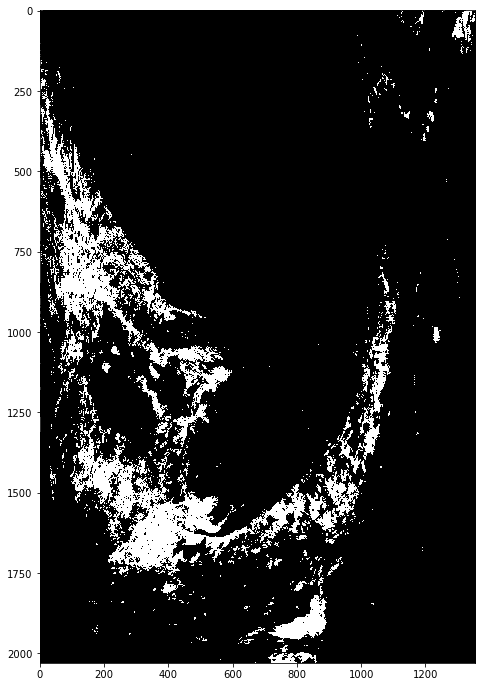

In [23]:
fig = plt.figure(figsize=(25,12))
plt.imshow(smoke_mask, cmap='gray', interpolation='none')
plt.savefig('smoke_mask.png', bbox_inches='tight')

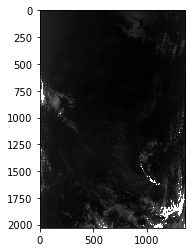

In [222]:
plt.imshow(im_for_show, cmap='gray', interpolation='none')
plt.show()

## References

Image classification with Random Forests: http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html
Classification Score on random forests: https://stats.stackexchange.com/questions/125756/classification-score-for-random-forest
Parameter tuning in random forests: https://stackoverflow.com/questions/36107820/how-to-tune-parameters-in-random-forest-using-scikit-learn
Splitting datasets for cross validation: https://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat